In [78]:
from function.graph import * # fichier qui regroupe les fonctions pour faire les graphes
from function.follow import *  # fichier qui regroupe les fonctions sur les follows
from function.hashtags import * # fichier qui regoupe les fonctions pour analyser les hashtags
from function.figure import *
from function.recover import get_dataframe_from_table
from function.preprocessing import *
import community
import networkx as nx

In [79]:
data=get_frensh_tweets_dataframe("tweets_0415_0423",1000)

MySQL connection is closed


# Preprocessing text

In [29]:
tweets = data["text"].values
new_tweets=preprocessing(tweets)


# **Vectorisation des données**

In [30]:
k=12

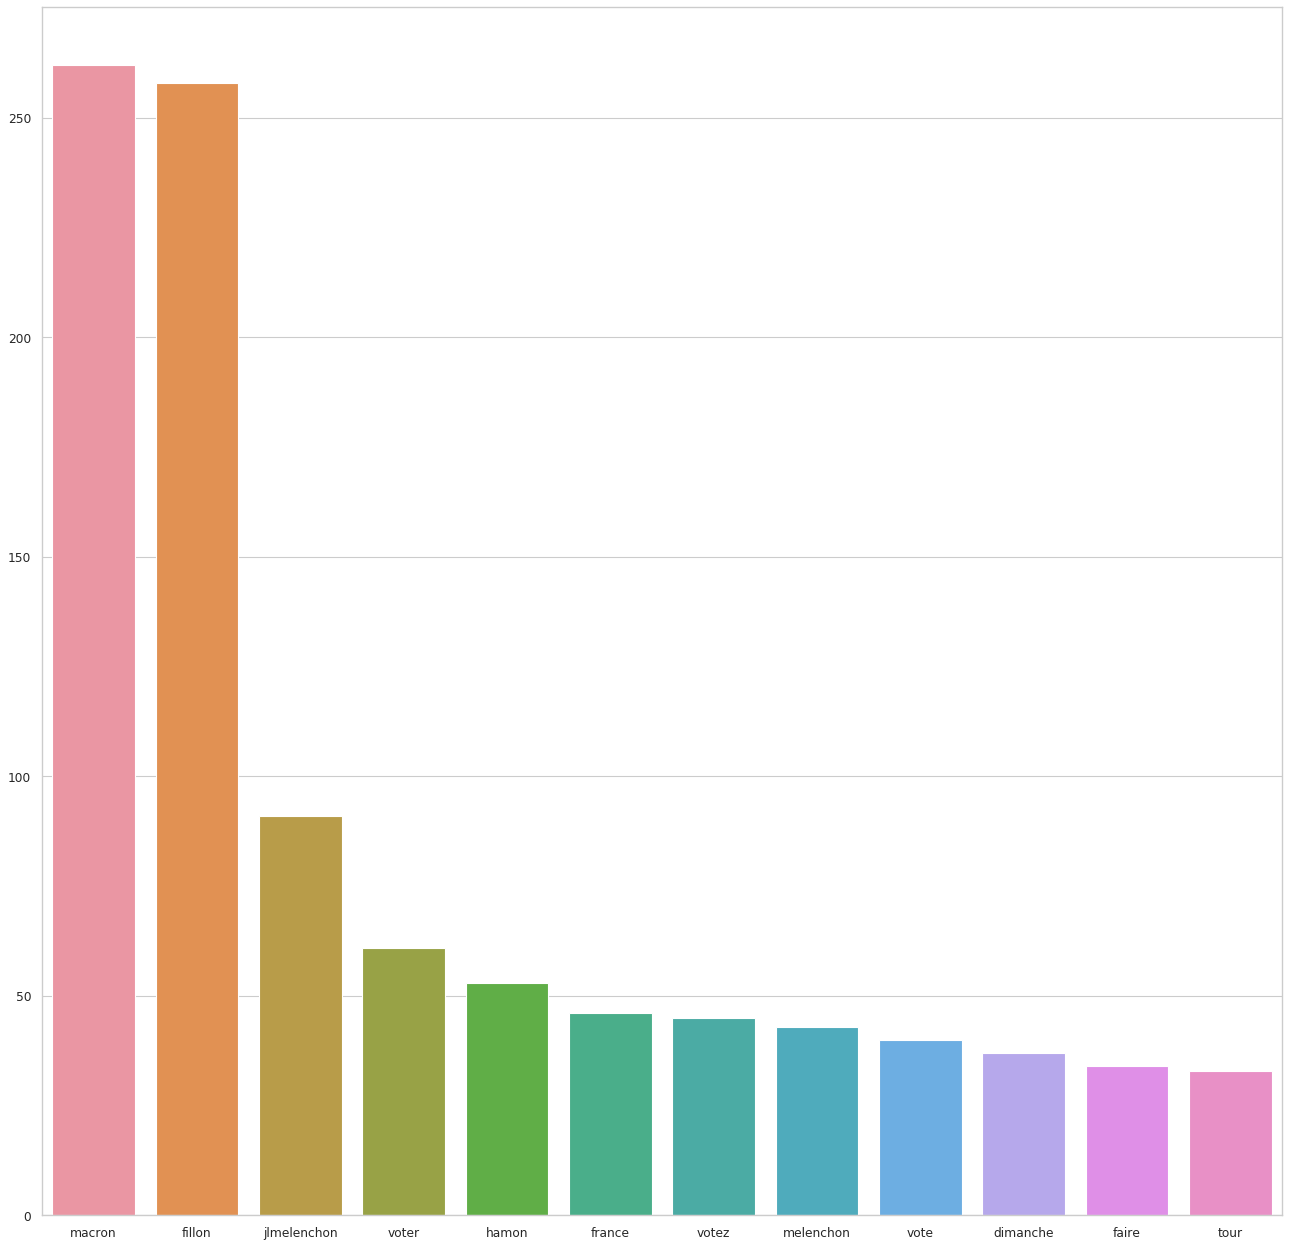

In [31]:
histogramme_vectorised_data(new_tweets,1,k)

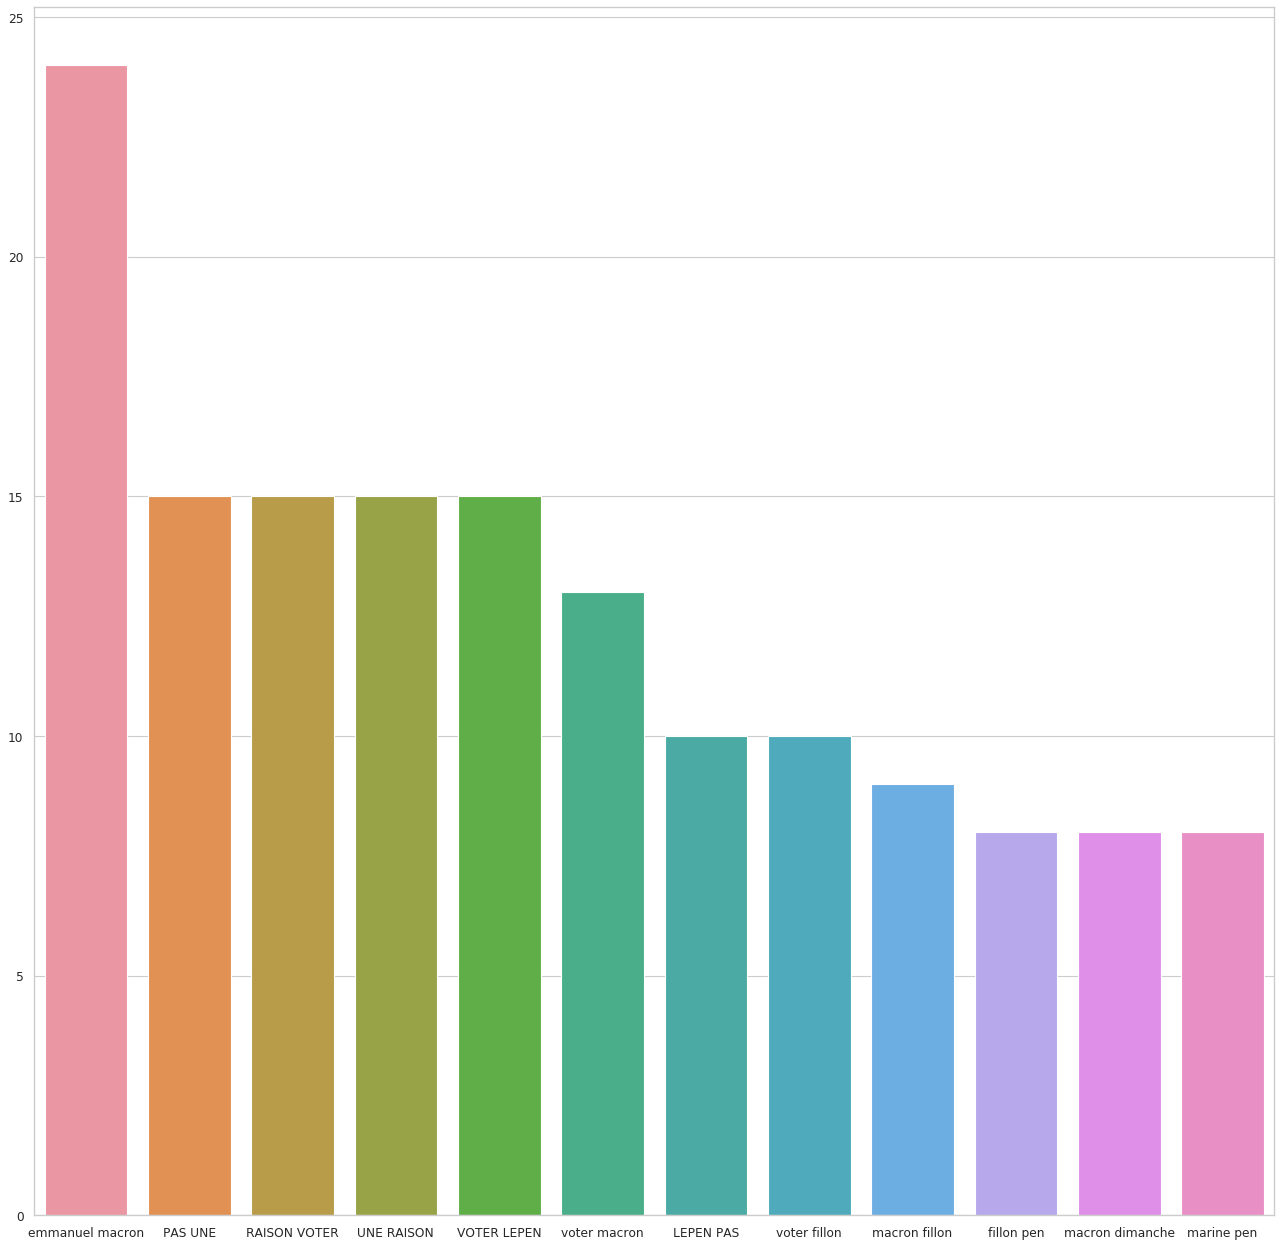

In [32]:
histogramme_vectorised_data(new_tweets,2,k)

# CLASSIFICATION DE TWEETS PAR THEME

# Tweets graph

In [33]:
part_retweets = True
part_figure = True
part_hashtags = True
part_hashtags2 = True

In [34]:
# définition à la main du dictionnaire pour rassembler les hashtags sur un hashtag commun
dict_candidat = {'macron': ['macron', 'EnMarche', 'MacronBercy', 'JeVoteMacron', 'Macron2017'],
                 'fillon': ['fillon', 'Fillon2017', 'JeVoteFillon', 'FillonPresident'],
                 'jlm': ['JLM2017', 'Mélenchon', 'LaForcedupeuple', 'JLMToulouse', 'AuNomDuPeuple', 'FranceInsoumise'],
                 'lepen': ['Marine2017', 'LePen', 'MarineLePen', 'MarineÀParis'],
                 'hamon': ['Hamon2017', 'Hamon']}
index_cand = np.concatenate(list(dict_candidat.values()))
data_cand = ['macron']*5 + ['fillon']*4 + ['jlm']*6 + ['lepen']*4 + ['hamon']*2

In [35]:
# recover data
users = get_dataframe_from_table("users_0415_0423")

Total number of rows in users_0415_0423 is:  681638
MySQL connection is closed


In [36]:
# compute number of tweet per user
tweets = get_dataframe_from_table("tweets_0415_0423",columns = ['tweet_id','user_id'])
tweets['nb_tweets'] = pd.Series(np.ones(tweets.shape[0])).values
tweets_count = tweets[['user_id', 'nb_tweets']].groupby('user_id').count()
users['nb_tweets'] = users.user_id.map(pd.Series(index=tweets_count.index, data=tweets_count.nb_tweets))

Total number of rows in tweets_0415_0423 is:  5414858
MySQL connection is closed


In [37]:
# select users with more than 100 tweets
users_reduced = users[users.nb_tweets > 100]

In [38]:
# recover data about media
media = get_dataframe_from_table("medias_0415_0423")

Total number of rows in medias_0415_0423 is:  644470
MySQL connection is closed


In [39]:
if part_hashtags:
    # recover tweets and hashtags data
    hashs = get_dataframe_from_table("hashs_0415_0423")
    hash_tweets = get_dataframe_from_table("tweet_hash_0415_0423")
    tweets = get_dataframe_from_table("tweets_0415_0423",columns = ['tweet_id','user_id'])

    # add column containing hashtag content in hash_tweets
    hashs['hash_id'] = hashs['hash_id'].apply(int)
    hash_tweets['hash'] = hash_tweets.hash_id.map(pd.Series(index=hashs.hash_id.values, data=hashs.hash.values))

    # on garde les hashtags qui sont dans le dictionnaire défini au début
    hash_tweets = hash_tweets[hash_tweets.hash.isin(np.concatenate(list(dict_candidat.values())))]
    # ajout d'une colonne pour le user qui a écrit le hashtag
    hash_tweets['user_id'] = hash_tweets.tweet_id.map(pd.Series(index = tweets.tweet_id.values, data = tweets.user_id.values))

    # on regroupe les hashtags ( jlm,jlm2017,jlmToulouse ---> jlm)
    hash_tweets['hash_simplified'] = hash_tweets.hash.map(pd.Series(index=index_cand, data=data_cand))

    #on sélectionne les hashtags des users qui ont au moins 100 tweets
    hash_tweets = hash_tweets[hash_tweets.user_id.isin(users_reduced.user_id.values)]
    tmp = hash_tweets[['user_id','hash_simplified']].groupby('user_id').hash_simplified.apply(list)

    #on ajoute une colonne dans la table des users, contenant les hashtags qu'ils ont écrit
    users_reduced['hashtags'] = users_reduced.user_id.map(tmp)
    # calcul de l'entropie
    users_reduced = entropy_hashtags(users_reduced)
    # définition de l'affinité politique
    users_reduced = politic_affinity((users_reduced))

Total number of rows in hashs_0415_0423 is:  48250
MySQL connection is closed
Total number of rows in tweet_hash_0415_0423 is:  4362001
MySQL connection is closed
Total number of rows in tweets_0415_0423 is:  5414858
MySQL connection is closed


/home/ghada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ghada/Bureau/Codes python/tweeter_project/function/hashtags.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users['hashtag_entropy'] = users.hashtags.apply(lambda x: np.array(x))
/home/ghada/Bureau/Codes python/tweeter_project/function/hashtags.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

23        1.000000
244       0.748327
341       1.322179
456       0.721928
612       1.205161
            ...   
678973    1.248575
679056   -0.000000
679988    1.405993
680012   -0.000000
680154    1.156112
Name: hashtag_entropy, Length: 8095, dtype: float64


In [41]:
if part_retweets:
    # on récupere la table des tweets avec les informations sur les retweets
    tweets = get_dataframe_from_table("tweets_0415_0423",
                                    columns=['tweet_id', 'user_id', 'retweeted_status_id', 'retweeted_user_id'])
    #calcul de nombre de fois qu'une personne est retweetée
    retweeted_count = tweets[['user_id','retweeted_user_id']].groupby('retweeted_user_id').count()
    users_reduced['retweeted_count'] = users_reduced.user_id.map(pd.Series(index=retweeted_count.index, data=retweeted_count.user_id.values))

    #calcul du nombre de fois qu'un user retweet
    retweeter_count = tweets[~tweets.retweeted_user_id.isin([None])][['user_id','retweeted_user_id']].groupby('user_id').count()
    users_reduced['retweeter_count'] = users_reduced.user_id.map(pd.Series(index=retweeter_count.index, data=retweeter_count.retweeted_user_id.values))

    users_reduced = users_reduced.astype(object).replace('None',0) # on remplace les np.nan par des None
    users_reduced = users_reduced.astype(object).replace(np.nan,0) # on remplace les np.nan par des None

    # partitionnement par rapport aux nb tweets, retweeted/retweeter count en utilisant KMeans
    users_reduced['cluster_id'] = supervised(users_reduced,['nb_tweets','retweeter_count','retweeted_count'])

Total number of rows in tweets_0415_0423 is:  5414858
MySQL connection is closed


/home/ghada/Bureau/Codes python/tweeter_project/function/figure.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_of_tweets = num_of_tweets[users.nb_tweets >= paliers[i]].shape[0]


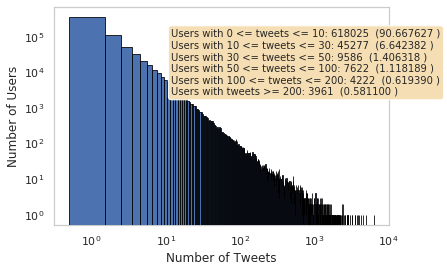

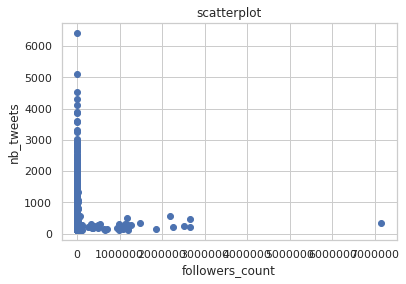

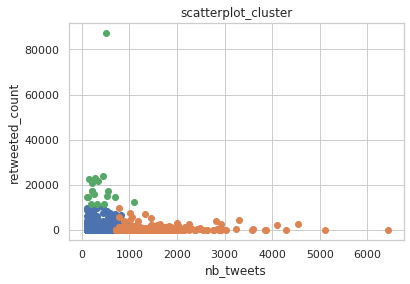

In [42]:
if part_figure:
    hist_user_tweet(users)
    scatterplot(users_reduced,'followers_count','nb_tweets',title='scatterplot',filename='nb_foll_nb_tweets_scatter')
    scatterplot_cluster(users_reduced,'nb_tweets','retweeted_count',title='scatterplot_cluster',filename='cluster_nb_tweets_retweeted_scatter')
    # on écrit le fichier de graphe des retweets
    write_retweets_gml(tweets, users_reduced)
    G = nx.read_gml('./data/retweets1.gml',label=None)
    partition = community.best_partition(G)
    users_reduced['louvain'] = users_reduced.user_id.map(pd.Series(index = list(partition.keys()),data = list(partition.values())))



In [43]:
users_final = users_reduced[~users_reduced.louvain.isin([np.nan])]

In [44]:
def hist_hashtags(df,filename = None):
    """calcule l'hist des hashtags pour une df"""
    flatten = lambda l: [item for sublist in l for item in sublist]
    hashtags = pd.Series(flatten(list(df.hashtag_origin.values)))
    hist = hashtags.value_counts()[:15].plot(kind='bar')
    hist.set_xticklabels(hist.get_xticklabels(), rotation=45, horizontalalignment='right')
    if filename is not None:
        plt.savefig('./figures/%s.pdf'%filename,bbox_inches='tight')

def moy_hashtag(df,hashtag):
    """calcule la fréquence d'apparation du hashtags dans les tweets pour chaque user"""
    bool_hash = df.hashtag_origin.apply(lambda x: hashtag in x)
    bool_hash = bool_hash[bool_hash == True]
    res = len(bool_hash)/len(df)
    return res



In [45]:
if part_hashtags2:
    # recover tweets and hashtags data
    hashs = get_dataframe_from_table("hashs_0415_0423")
    hash_tweets = get_dataframe_from_table("tweet_hash_0415_0423")
    tweets = get_dataframe_from_table("tweets_0415_0423",columns = ['tweet_id','user_id'])

    # add column containing hashtag content in hash_tweets
    hashs['hash_id'] = hashs['hash_id'].apply(int)
    hash_tweets['hash'] = hash_tweets.hash_id.map(pd.Series(index=hashs.hash_id.values, data=hashs.hash.values))

    # ajout d'une colonne pour le user qui a écrit le hashtag
    hash_tweets['user_id'] = hash_tweets.tweet_id.map(pd.Series(index = tweets.tweet_id.values, data = tweets.user_id.values))

    #on sélectionne les hashtags des users qui ont au moins 100 tweets
    hash_tweets = hash_tweets[hash_tweets.user_id.isin(users_final.user_id.values)]
    tmp = hash_tweets[['user_id','hash']].groupby('user_id').hash.apply(list)

    #on ajoute une colonne dans la table des users, contenant les hashtags qu'ils ont écrit
    users_final['hashtag_origin'] = users_reduced.user_id.map(tmp)


    contre_fillon = users_final[users_final.louvain == 0]
    pour_macron = users_final[users_final.louvain == 1]
    contre_macron = users_final[users_final.louvain == 4][users_final.politic_affinity== 'macron']
    pour_fillon = users_final[users_final.louvain == 4][users_final.politic_affinity== 'fillon']

Total number of rows in hashs_0415_0423 is:  48250
MySQL connection is closed
Total number of rows in tweet_hash_0415_0423 is:  4362001
MySQL connection is closed
Total number of rows in tweets_0415_0423 is:  5414858
MySQL connection is closed


/home/ghada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ghada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ghada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


# latent semantic analysis

In [52]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

In [73]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [74]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [75]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values